<a id='sec0'></a>
# Calibrating the model used in 1st submission
1. <a href='#sec1'>Import Modules and Data</a><br>
<br>
2. <a href='#sec2'>Digitize both train and test sets</a><br>
<br>
3. <a href='#sec3'>Create subset of feature spaces</a>
    - Use features from F001 univariate selection<br>
<br>
4. <a href='#sec4'>Resample train set</a>
    - Tomek Link majority
    - Undersample majority, oversample minority<br>
<br>  
5. <a href='#sec5'>Train XGBoost, make a prediction, save result</a><br>

<a id='sec1'></a>
# Import Modules and Data
(<a href='#sec0'>back to top</a>)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import my_scoring_functions as msf

%matplotlib inline

In [2]:
from ps.feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

In [31]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

In [32]:
print('Train Set Shape: ', train.shape)
print(' Test Set Shape: ', test.shape)

Train Set Shape:  (595212, 59)
 Test Set Shape:  (892816, 58)


<a id='sec2'></a>
# Digtizing train and test sets
(<a href='#sec0'>back to top</a>)

In [5]:
trainset_digitized = pd.read_csv('./data/digitized_trainset1.csv')
testset_digitized = pd.read_csv('./data/digitized_testset1.csv')

In [6]:
trainset_digitized.shape

(595212, 228)

In [7]:
trainset_digitized.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       ...
       'ps_ind_04_cat_1', 'ps_ind_05_cat_NaN', 'ps_ind_05_cat_0',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'target'],
      dtype='object', length=228)

<a id='sec3'></a>
# Selecting Features
(<a href='#sec0'>back to top</a>)

In [8]:
# Get a list of features selected after univariate selection and RFE
rfe = pd.read_csv('./data/rfe_features.csv')
rfe_features = list(rfe.columns)

In [9]:
trainset_ready = trainset_digitized.loc[:, rfe_features]
testset_ready = testset_digitized.loc[:, rfe_features]

In [10]:
print('Final Train Set Shape: ', trainset_ready.shape)
print('Final  Test Set Shape: ', testset_ready.shape)

Final Train Set Shape:  (595212, 108)
Final  Test Set Shape:  (892816, 108)


In [11]:
print('target' in trainset_ready.columns)
print('target' in testset_ready.columns)

False
False


<a id='sec4'></a>
# Resample Train Set
(<a href='#sec0'>back to top</a>)

In [12]:
trainset_ready.columns

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_12_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_car_01_cat_0', 'ps_car_01_cat_6',
       ...
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03',
       'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03'],
      dtype='object', length=108)

In [13]:
trainset_digitized.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       ...
       'ps_ind_04_cat_1', 'ps_ind_05_cat_NaN', 'ps_ind_05_cat_0',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'target'],
      dtype='object', length=228)

In [14]:
X = np.array(trainset_ready)
y = np.array(trainset_digitized.iloc[:, -1])

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (595212, 108)
y shape:  (595212,)


In [15]:
%%time
# Tomek Links to denoise majority
if False:
    tl = TomekLinks(n_jobs=8, ratio='majority')
    X_tl, y_tl = tl.fit_sample(X, y)

    print('Before tomek links: size of X: ', X.shape)
    print('After  tomek links: size of X: ', X_tl.shape)
    print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
    print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [16]:
# Set targets for the number of each class
# Here, set class0:class1 = 1:1
num_class1 = np.sum(y)
num_class1_to_resample = 5 * num_class1
num_class0_to_resample = int(3 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X, y)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

In [17]:
# Print Resampling Results
#print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_res.shape)
#print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

After  Resampling: size of X:  (433880, 108)
After  Resampling: class0/class1 = 325410/108470


<a id='sec5'></a>
# Train XGBoost, predict probabilities, save to a file
(<a href='#sec0'>back to top</a>)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1)

In [20]:
# Train XGBoost
clf = XGBClassifier(gamma=9, subsample=0.85, max_depth=11, 
                    min_child_weight=4, learning_rate=0.05, 
                    n_estimators=500, n_jobs=8)

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.05, max_delta_step=0,
       max_depth=11, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)

In [23]:
from importlib import reload

In [24]:
reload(msf)

<module 'my_scoring_functions' from '/home/ryohayama/python_current/porto_seguro/my_scoring_functions.py'>

XGB:
	Gini: 0.857
	Precision: 1.000
	Recall: 0.804
	F1: 0.891
	Ave. Precision Score: 0.911

XGB + Sigmoid:
	Gini: 0.857
	Precision: 0.986
	Recall: 0.809
	F1: 0.889
	Ave. Precision Score: 0.911



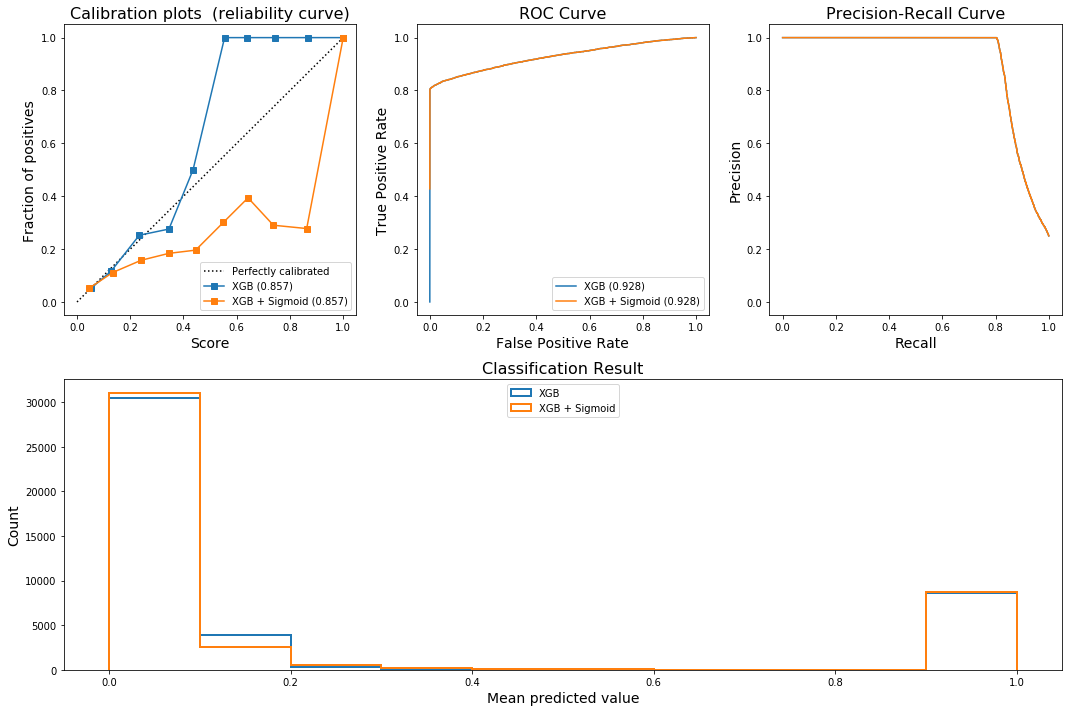

CPU times: user 32min 31s, sys: 810 ms, total: 32min 32s
Wall time: 4min 7s


In [25]:
%%time
# Use custom function to run calibrations (see my_scoring_functions.py) 
d = [X_train, X_test, y_train, y_test]
clfs = msf.plot_calibration_curve_ps(clf, 'XGB', 1, d, cv='prefit')

In [29]:
neo_clf = clfs[1].calibrated_classifiers_[0]

In [33]:
if False:
    X_test = np.array(testset_ready)
    y_ids = np.array(test.id)

    X_test.shape, y_ids.shape

    y_probas = neo_clf.predict_proba(X_test)

    y_probas.shape

    prediction_result = pd.DataFrame({'id': y_ids, 'target': y_probas[:, 1]})
    prediction_result = prediction_result[['id', 'target']]

    prediction_result.head(10)

    prediction_result.to_csv('./submissions/porto_seguro_submission_RH10.csv', index=False, header=True)